In [ ]:
# Imports and data prep

notes for hirarchical forecasting reconcilliation



# Notizen

NeuralProphet:

no categoricals

regressors have to be added individually

maybe ID to make multiple timeseries work but this doesnt really seem possible

global modeling:
https://neuralprophet.com/notebooks/global_modeling.html

critic:
https://valeman.medium.com/benchmarking-neural-prophet-part-i-neural-prophet-vs-prophet-252990763468


which baseline are available from google as code?


MQRNN for complex dataset
https://github.com/tianchen101/MQRNN/blob/master/MQRNN.py

DeepAR for univariate implemented in PyTorch Forecasting
Seq2Seq/ConvTrans best performance

cited implementation [12]
https://github.com/mlpotter/Transformer_Time_Series
https://github.com/AIStream-Peelout/flow-forecast




NEXT STEPS:

-make grocery work
-turn data prep into script
-try tft with grocery data 10%
-try MQRNN
-try SEQ2SEQ / ConvTrans


What did we do till now?

try google implementation, dependency issues

use pytorch forecasting implementation

use pytorch lightning for training automation
first training on CPU locally, MAE of 50


first succesfull training in colab --> MAE=10

put model on server with gpu
ca. 2 iteration/sec

distributed computing on 3 Tesla A100:
3 iteration/sec

-->see multi gpu as optional later

identify Learning rate as main hurdle
google optimal=0,001 takes a very long time to optimize
--> use Learning rate scheduler

saving model checkpoints, problem: also need to save optimizer checkpoints

find a way to print Learning rate during trainer
manage to reload model/trainer state to continue training
realized, that TFT has automated learning rate decay on plateau, also using LR_scheduler from lightning inside lightnings optimizer, optimizer arg has to be passed to tft for proper checkpointing


Training on GPU:
theoretically Tesla A100 available, however so often in use, that we opted for using Tesla V100 which were more readily available

Using same parameters as described in the Google paper, we achieve a network size of 1.7 Million, while google says it has 168k parameters.
we are also using state size of 160 like google, however for the PytorchForecasting TFT we had to define hidden_continues_size, which google did not define. According to recommendation from TFT documentation we used 1/2 of initial hidden size = 80

with 10x parameter size each epoch takes around 2h10min / 130min, which is around 2x-2.5x as long as the google paper took per epoch, when doing the same number of epoch as google (7), a full training run will take around 15h, which is still feasable. this run had 33k entries per epoch and 4,2iter/sec

next try, 0,95 patch size, all same values suddenly has 16k entries and 2,8 iter/sec

vom datensatz wird nur eine range von 250 tagen benutzt, wie im google paper und auch anderen papern

using Learningrate of 0.005, which will be reduced to 0.001 after plateau on 2 epochs

having to restart training multiple times from checkpoint, because ssh connection to server is usually interrupted after idling for a ouple of hours, even while training is running

Pytorch lightning & forecasting are very powerfull but integrating them, documentation dont show the full picture of what has to be done or can be done. a lot of trial and error and using github-issues was nessesary

reaching loss of around 20 after 7 full epoch like the google paper

--> checking dataset input again and realizing, that google is mostly using numerical input, where we are using numerical+categorical, e.g. for day_of_week
variable number doesnt have an influence on model size, but less noise,etc could improve model + training time

-achieving better loss=20 with hidden=40, hidden_conitinuous=20

-just using googles variables for the timeseries dataset, training is speeding up to 70min/epoch

model size is now 1.6 million

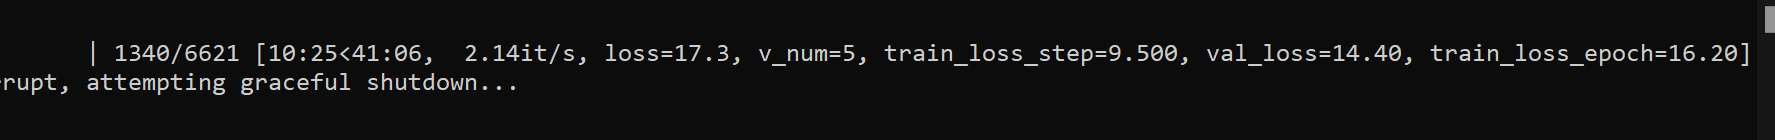

In [4]:
%%capture
# installing and loading all needed modules

#!pip install pytorch-forecasting
#!pip install pytorch-forecasting[mqf2]
#!pip install wget
#!pip install pyunpack
#!pip install optuna

# install ai based autocomplete
#!pip3 install jupyter-tabnine --user
#!jupyter nbextension install --py jupyter_tabnine --user
#!jupyter nbextension enable --py jupyter_tabnine --user
#!jupyter serverextension enable --py jupyter_tabnine --user
#!pip install neuralprophet[live]

import neuralprophet
import sys
import optuna
import wget
import os
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
import pickle
import tensorflow as tf
import tensorboard as tb
import time
import matplotlib.pyplot as plt
import pyunpack
import glob
import gc
import sklearn.preprocessing

from neuralprophet import NeuralProphet, set_log_level
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, NHiTS, DeepAR
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data.examples import get_stallion_data
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
#from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from pyunpack import Archive
from torch import nn
from datetime import timedelta
from pytorch_lightning.callbacks import DeviceStatsMonitor

# run to prevent compatibilty issues with tensorflow/tensorboard/pytorch
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

#from google.colab import drive
#drive.mount('/content/drive')

from dataloading_helpers import electricity_dataloader, retail_dataloader, electricity_formatter
from config import *

dataloading_helpers.electricity_formatter.ElectricityFormatter

In [2]:
log_folder = CONFIG_DICT["models"]["electricity"]
writer = SummaryWriter(log_folder)
#%tensorboard --logdir=log_folder
#%load_ext tensorboard
#%reload_ext tensorboard
#%tensorboard --logdir=log_folder

In [47]:
DataTypes = google_helpers.DataTypes
InputTypes = google_helpers.InputTypes


class FavoritaFormatter(google_helpers.GenericDataFormatter):
    """Defines and formats data for the Favorita dataset.
    Attributes:
        column_definition: Defines input and data type of column used in the
        experiment.
    identifiers: Entity identifiers used in experiments.
    """

    _column_definition = [
        ('traj_id', DataTypes.REAL_VALUED, InputTypes.ID),
        ('date', DataTypes.DATE, InputTypes.TIME),
        ('log_sales', DataTypes.REAL_VALUED, InputTypes.TARGET),
        ('onpromotion', DataTypes.CATEGORICAL, InputTypes.KNOWN_INPUT),
        ('transactions', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('oil', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('day_of_week', DataTypes.CATEGORICAL, InputTypes.KNOWN_INPUT),
        ('day_of_month', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('month', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('national_hol', DataTypes.CATEGORICAL, InputTypes.KNOWN_INPUT),
        ('regional_hol', DataTypes.CATEGORICAL, InputTypes.KNOWN_INPUT),
        ('local_hol', DataTypes.CATEGORICAL, InputTypes.KNOWN_INPUT),
        ('open', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('item_nbr', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('store_nbr', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('city', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('state', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('type', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('cluster', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('family', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('class', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('perishable', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT)
    ]

    def __init__(self):
        """Initialises formatter."""

        self.identifiers = None
        self._real_scalers = None
        self._cat_scalers = None
        self._target_scaler = None
        self._num_classes_per_cat_input = None

    def split_data(self, df, valid_boundary=None, test_boundary=None):
        """Splits data frame into training-validation-test data frames.
        This also calibrates scaling object, and transforms data for each split.
        Args:
          df: Source data frame to split.
          valid_boundary: Starting year for validation data
          test_boundary: Starting year for test data
        Returns:
          Tuple of transformed (train, valid, test) data.
        """

        print('Formatting train-valid-test splits.')

        if valid_boundary is None:
            valid_boundary = pd.datetime(2015, 12, 1)

        fixed_params = self.get_fixed_params()
        time_steps = fixed_params['total_time_steps']
        lookback = fixed_params['num_encoder_steps']
        forecast_horizon = time_steps - lookback

        df['date'] = pd.to_datetime(df['date'])
        df_lists = {'train': [], 'valid': [], 'test': []}
        for _, sliced in df.groupby('traj_id'):
            index = sliced['date']
            train = sliced.loc[index < valid_boundary]
            train_len = len(train)
            valid_len = train_len + forecast_horizon
            valid = sliced.iloc[train_len - lookback:valid_len, :]
            test = sliced.iloc[valid_len - lookback:valid_len + forecast_horizon, :]

            sliced_map = {'train': train, 'valid': valid, 'test': test}

            for k in sliced_map:
                item = sliced_map[k]

                if len(item) >= time_steps:
                    df_lists[k].append(item)

        dfs = {k: pd.concat(df_lists[k], axis=0) for k in df_lists}

        train = dfs['train']
        self.set_scalers(train, set_real=True)

        # Use all data for label encoding  to handle labels not present in training.
        self.set_scalers(df, set_real=False)

        # Filter out identifiers not present in training (i.e. cold-started items).
    def filter_ids(frame):
        identifiers = set(self.identifiers)
        index = frame['traj_id']
        return frame.loc[index.apply(lambda x: x in identifiers)]

        valid = filter_ids(dfs['valid'])
        test = filter_ids(dfs['test'])

        return (self.transform_inputs(data) for data in [train, valid, test])

    def set_scalers(self, df, set_real=True):
        """Calibrates scalers using the data supplied.
        Label encoding is applied to the entire dataset (i.e. including test),
        so that unseen labels can be handled at run-time.
        Args:
          df: Data to use to calibrate scalers.
          set_real: Whether to fit set real-valued or categorical scalers
        """
        print('Setting scalers with training data...')

        column_definitions = self.get_column_definition()
        id_column = utils.get_single_col_by_input_type(InputTypes.ID,
                                                       column_definitions)
        target_column = utils.get_single_col_by_input_type(InputTypes.TARGET,
                                                           column_definitions)

        if set_real:
            # Extract identifiers in case required
            self.identifiers = list(df[id_column].unique())

            # Format real scalers
            self._real_scalers = {}
            for col in ['oil', 'transactions', 'log_sales']:
                self._real_scalers[col] = (df[col].mean(), df[col].std())

            self._target_scaler = (df[target_column].mean(), df[target_column].std())

        else:
            # Format categorical scalers
            categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})

            categorical_scalers = {}
            num_classes = []
            if self.identifiers is None:
                raise ValueError('Scale real-valued inputs first!')
            id_set = set(self.identifiers)
            valid_idx = df['traj_id'].apply(lambda x: x in id_set)
            for col in categorical_inputs:
                # Set all to str so that we don't have mixed integer/string columns
                srs = df[col].apply(str).loc[valid_idx]
                categorical_scalers[col] = sklearn.preprocessing.LabelEncoder().fit(srs.values)

            num_classes.append(srs.nunique())

            # Set categorical scaler outputs
            self._cat_scalers = categorical_scalers
            self._num_classes_per_cat_input = num_classes

    def transform_inputs(self, df):
        """Performs feature transformations.
        This includes both feature engineering, preprocessing and normalisation.
        Args:
          df: Data frame to transform.
        Returns:
          Transformed data frame.
        """
        output = df.copy()

        if self._real_scalers is None and self._cat_scalers is None:
            raise ValueError('Scalers have not been set!')

        column_definitions = self.get_column_definition()

        categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})

        # Format real inputs
        for col in ['log_sales', 'oil', 'transactions']:
            mean, std = self._real_scalers[col]
            output[col] = (df[col] - mean) / std

            if col == 'log_sales':
                output[col] = output[col].fillna(0.)  # mean imputation

        # Format categorical inputs
        for col in categorical_inputs:
            string_df = df[col].apply(str)
            output[col] = self._cat_scalers[col].transform(string_df)

        return output

In [73]:
def unzip(zip_path, output_file, data_folder):
    """Unzips files and checks successful completion."""

    print('Unzipping file: {}'.format(zip_path))
    pyunpack.Archive(zip_path).extractall(data_folder)

    # Checks if unzip was successful
    if not os.path.exists(output_file):
        raise ValueError(
          'Error in unzipping process! {} not found.'.format(output_file))

def process_favorita():
    """Processes Favorita dataset.
    Makes use of the raw files should be manually downloaded from Kaggle @
    https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data
    Args:
      config: Default experiment config for Favorita
    """

    url = 'https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data'

    data_folder = CONFIG_DICT['datasets']['retail']

    # Save manual download to root folder to avoid deleting when re-processing.
    zip_file = os.path.join(data_folder, 'favorita-grocery-sales-forecasting.zip')

    if not os.path.exists(zip_file):
        raise ValueError(
            'Favorita zip file not found in {}!'.format(zip_file) +
            ' Please manually download data from Kaggle @ {}'.format(url))

    # Unpack main zip file
    outputs_file = os.path.join(data_folder, 'train.csv.7z')
    unzip(zip_file, outputs_file, data_folder)

    # Unpack individually zipped files
    for file in glob.glob(os.path.join(data_folder, '*.7z')):
        csv_file = file.replace('.7z', '')
        unzip(file, csv_file, data_folder)

    print('Unzipping complete, commencing data processing...')

    # Extract only a subset of data to save/process for efficiency
    start_date = pd.datetime(2015, 1, 1)
    end_date = pd.datetime(2016, 6, 1)

    print('Regenerating data...')

    # load temporal data
    temporal = pd.read_csv(os.path.join(data_folder, 'train.csv'), index_col=0)

    store_info = pd.read_csv(os.path.join(data_folder, 'stores.csv'), index_col=0)
    oil = pd.read_csv(os.path.join(data_folder, 'oil.csv'), index_col=0).iloc[:, 0]
    holidays = pd.read_csv(os.path.join(data_folder, 'holidays_events.csv'))
    items = pd.read_csv(os.path.join(data_folder, 'items.csv'), index_col=0)
    transactions = pd.read_csv(os.path.join(data_folder, 'transactions.csv'))

    # Take first 6 months of data
    temporal['date'] = pd.to_datetime(temporal['date'])

    # Filter dates to reduce storage space requirements
    if start_date is not None:
        temporal = temporal[(temporal['date'] >= start_date)]
    if end_date is not None:
        temporal = temporal[(temporal['date'] < end_date)]

    dates = temporal['date'].unique()

    # Add trajectory identifier
    temporal['traj_id'] = temporal['store_nbr'].apply(str) + '_' + temporal['item_nbr'].apply(str)
    temporal['unique_id'] = temporal['traj_id'] + '_' + temporal['date'].apply(str)

    # Remove all IDs with negative returns
    print('Removing returns data')
    min_returns = temporal['unit_sales'].groupby(temporal['traj_id']).min()
    valid_ids = set(min_returns[min_returns >= 0].index)
    selector = temporal['traj_id'].apply(lambda traj_id: traj_id in valid_ids)
    new_temporal = temporal[selector].copy()
    del temporal
    gc.collect()
    temporal = new_temporal
    temporal['open'] = 1

    # Resampling
    print('Resampling to regular grid')
    resampled_dfs = []
    for traj_id, raw_sub_df in temporal.groupby('traj_id'):
       # print('Resampling', traj_id)
        sub_df = raw_sub_df.set_index('date', drop=True).copy()
        sub_df = sub_df.resample('1d').last()
        sub_df['date'] = sub_df.index
        sub_df[['store_nbr', 'item_nbr', 'onpromotion']] = sub_df[['store_nbr', 'item_nbr', 'onpromotion']].fillna(method='ffill')
        sub_df['open'] = sub_df['open'].fillna(0)  # flag where sales data is unknown
        sub_df['log_sales'] = np.log(sub_df['unit_sales'])
        resampled_dfs.append(sub_df.reset_index(drop=True))

    new_temporal = pd.concat(resampled_dfs, axis=0)
    del temporal
    gc.collect()
    temporal = new_temporal

    print('Adding oil')
    oil.name = 'oil'
    oil.index = pd.to_datetime(oil.index)
    
    #fill oil dates and add nan, was handled differently in older pandas version
    idx = pd.date_range('01-01-2013', '08-30-2017')
    oil = oil.reindex(idx, fill_value="NaN")
    
    temporal = temporal.join(oil.loc[dates].fillna(method='ffill'), on='date', how='left')
    temporal['oil'] = temporal['oil'].fillna(-1)

    
    print('Adding store info')
    temporal = temporal.join(store_info, on='store_nbr', how='left')

    print('Adding item info')
    temporal = temporal.join(items, on='item_nbr', how='left')

    transactions['date'] = pd.to_datetime(transactions['date'])
    temporal = temporal.merge(
      transactions,
      left_on=['date', 'store_nbr'],
      right_on=['date', 'store_nbr'],
      how='left')
    temporal['transactions'] = temporal['transactions'].fillna(-1)

    # Additional date info
    temporal['day_of_week'] = pd.to_datetime(temporal['date'].values).dayofweek
    temporal['day_of_month'] = pd.to_datetime(temporal['date'].values).day
    temporal['month'] = pd.to_datetime(temporal['date'].values).month

    # Add holiday info
    print('Adding holidays')
    holiday_subset = holidays[holidays['transferred'].apply(lambda x: not x)].copy()
    holiday_subset.columns = [s if s != 'type' else 'holiday_type' for s in holiday_subset.columns]
    holiday_subset['date'] = pd.to_datetime(holiday_subset['date'])
    local_holidays = holiday_subset[holiday_subset['locale'] == 'Local']
    regional_holidays = holiday_subset[holiday_subset['locale'] == 'Regional']
    national_holidays = holiday_subset[holiday_subset['locale'] == 'National']

    temporal['national_hol'] = temporal.merge(national_holidays, left_on=['date'], right_on=['date'], how='left')['description'].fillna('')
    temporal['regional_hol'] = temporal.merge(regional_holidays, left_on=['state', 'date'], right_on=['locale_name', 'date'], how='left')['description'].fillna('')
    temporal['local_hol'] = temporal.merge(local_holidays, left_on=['city', 'date'], right_on=['locale_name', 'date'], how='left')['description'].fillna('')

    temporal.sort_values('unique_id', inplace=True)

    print('Saving processed file to {}'.format(CONFIG_DICT['datasets']['retail']))
    temporal.to_csv(CONFIG_DICT['datasets']['retail'] / "favorita_csv")

In [74]:
process_favorita()

Unzipping file: C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_4\Information_Systems\TFT_project\RT1_TFT\data\retail\favorita-grocery-sales-forecasting.zip
Unzipping file: C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_4\Information_Systems\TFT_project\RT1_TFT\data\retail\holidays_events.csv.7z
Unzipping file: C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_4\Information_Systems\TFT_project\RT1_TFT\data\retail\items.csv.7z
Unzipping file: C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_4\Information_Systems\TFT_project\RT1_TFT\data\retail\oil.csv.7z
Unzipping file: C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_4\Information_Systems\TFT_project\RT1_TFT\data\retail\sample_submission.csv.7z
Unzipping file: C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_4\Information_Systems\TFT_project\RT1_TFT\data\retail\stores.csv.7z
Unzipping file: C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_4\Information_Systems\TFT_project\RT1_TFT\data\retail\

# Training TFT

In [10]:
electricity = electricity_dataloader.create_electricity_timeseries_tft()

timeseries_dict =  electricity
config_name_string = "electricity"
parameters = []

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198072 entries, 17544 to 10461486
Data columns (total 13 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   power_usage              float64 
 1   time_idx                 int32   
 2   days_from_start          int64   
 3   categorical_id           category
 4   date                     object  
 5   id                       object  
 6   hour                     int64   
 7   day                      int64   
 8   day_of_week              int64   
 9   month                    int64   
 10  hours_from_start         float64 
 11  categorical_day_of_week  int64   
 12  categorical_hour         int64   
dtypes: category(1), float64(2), int32(1), int64(7), object(2)
memory usage: 213.8+ MB


In [19]:
from dataloading_helpers import base
GenericDataFormatter = base.GenericDataFormatter

this = electricity_formatter.ElectricityFormatter()
#this.split_data(self, df=electricity, valid_boundary=1315, test_boundary=1339)


TypeError: Can't instantiate abstract class ElectricityFormatter with abstract method get_fixed_params

In [20]:
retail = retail_dataloader.create_retail_timeseries()

timeseries_dict =  retail
config_name_string = "retail"
parameters = []

In [133]:
csv_file = CONFIG_DICT["datasets"]["retail"] / "holidays_events.csv"
retail_data = pd.read_csv(csv_file, index_col=0)    
retail_data["locale"].value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

In [128]:
def create_retail_timeseries_tft():
    csv_file = CONFIG_DICT["datasets"]["retail"] / "retail_small.csv"
    try:
        retail_data = pd.read_csv(csv_file, index_col=0)    
    except:
        retail_data = prep_retail_data()

    retail_data["categorical_day_of_month"] = retail_data["day_of_month"]
    retail_data["categorical_month"] = retail_data["month"]
        
    categorical_list = ["store_nbr", "item_nbr", "family", "categorical_day_of_month", "categorical_month", "day_of_week", 
                        "onpromotion", "national_hol", "regional_hol", "local_hol", "type", "class", "perishable", "city", "state"]
    
    for var in categorical_list:
        retail_data[var] = retail_data[var].astype("string").astype("category")
        
    
    retail_data["datetime"] = pd.to_datetime(retail_data["date"])
    start_date =  retail_data["datetime"].min()
    retail_data["time_idx"] = (retail_data["datetime"] - start_date).dt.days
    retail_data['time_idx'] = retail_data['time_idx'].astype('int')

    print(retail_data.head())
    
    
    
    print(retail_data["national_hol"].value_counts())
        
    max_prediction_length = 24
    max_encoder_length = 168
    training_cutoff = retail_data["time_idx"].max() - max_prediction_length
        
    training = TimeSeriesDataSet(
      retail_data[lambda x: x.time_idx <= training_cutoff],
      time_idx="time_idx",
      target="log_sales",
      group_ids=["traj_id"],
      min_encoder_length=max_encoder_length,# // 2,  # keep encoder length long (as it is in the validation set)
      max_encoder_length=max_encoder_length,
      min_prediction_length=max_prediction_length,
      max_prediction_length=max_prediction_length,
      static_categoricals=["item_nbr", "store_nbr", "type",  "class", "perishable", "family",  "city", "state"],
      static_reals=[],
      time_varying_known_categoricals=["categorical_day_of_month", "day_of_week", "categorical_month", 
                                       "national_hol", "regional_hol", "local_hol"],
      #variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
      time_varying_known_reals=["day_of_month", "month", "open"],
      time_varying_unknown_categoricals=[],
      time_varying_unknown_reals=["oil", "transactions"],
      target_normalizer=GroupNormalizer(
          groups=["categorical_id", "id"], transformation="softplus"
      ),  # use softplus and normalize by group
      add_relative_time_idx=True,
      add_target_scales=True,
      add_encoder_length=False, #
    )

  # create validation set (predict=True) which means to predict the last max_prediction_length points in time
  # for each series
    validation = TimeSeriesDataSet.from_dataset(training, retail_data, predict=True, stop_randomization=True)

  # create dataloaders for model
    batch_size = 64  # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2)


# output data as dict for easier modularity
    return {"training_dataset": training, 
          "train_dataloader": train_dataloader,
          "val_dataloader": val_dataloader, 
          "validaton_dataset": validation}

In [8]:
log_folder = CONFIG_DICT["models"]["electricity"]
writer = SummaryWriter(log_folder)


version_number -> trainer.logger.version
epoch_number -> trainer.current_epoch
global_step -> trainer.global_step

lightning_logs/version_{version number}/epoch_{epoch number}-step_{global_step}.ckpt

TypeError: add_embedding() missing 1 required positional argument: 'mat'

In [4]:
model_path = Path("C:/Users/Benedikt/Desktop/Mein_Ordner/WI-INFO/Semester_4/Information_Systems/TFT_project/RT1_TFT/models/electricity/lightning_logs/version_8/checkpoints/epoch=1-step=20.ckpt")
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

if torch.cuda.is_available():
    accelerator = "gpu"
    devices = torch.cuda.current_device()
else:
    accelerator = "cpu"
    devices = None

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval='epoch')  # log the learning rate
logger = TensorBoardLogger(CONFIG_DICT["models"]["electricity"])  # logging results to a tensorboard
#DeviceStatsMonitor = DeviceStatsMonitor()

model_dir = CONFIG_DICT["models"][config_name_string] / "nachtraining"

trainer = pl.Trainer(
    default_root_dir=model_dir,
    max_epochs=6,
    accelerator=accelerator,
    devices=devices,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=10, 
    fast_dev_run=False,  
    callbacks=[lr_logger, early_stop_callback], #DeviceStatsMonitor],
    log_every_n_steps=1,
    logger=logger,
    profiler="simple",
    )

tft = TemporalFusionTransformer.from_dataset(
    timeseries_dict["training_dataset"],
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=80,
    output_size= 3,  # 7 quantiles by default
    loss=QuantileLoss([0.1, 0.5, 0.9]),
    log_interval=1,
    reduce_on_plateau_patience=2,
    optimizer="adam"
    )

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.optimizer = Adam(tft.parameters(), lr=0.1)
scheduler = ReduceLROnPlateau(trainer.optimizer)


Number of parameters in network: 1617.1k


In [5]:
trainer.fit(
    tft,
    train_dataloaders=timeseries_dict["train_dataloader"],
    val_dataloaders=timeseries_dict["val_dataloader"],
    #ckpt_path=model_path
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
tft.best

AttributeError: 'Trainer' object has no attribute 'best_model_path'

In [ ]:
model_path = Path("C:/Users/Benedikt/Desktop/Mein_Ordner/WI-INFO/Semester_4/Information_Systems/TFT_project/RT1_TFT/models/electricity/lightning_logs/version_5/checkpoints/epoch=1-step=20.ckpt")

model = TemporalFusionTransformer(),#optimizer="adam")
trainer = pl.Trainer()

trainer.fit(
    tft,
    train_dataloaders=timeseries_dict["train_dataloader"],
    val_dataloaders=timeseries_dict["val_dataloader"],
    ckpt_path=model_path
)

In [104]:
lightning_optimizer = trainer.optimizer
for param_groups in lightning_optimizer.param_groups:
    print(param_groups['lr'])


0.1


In [92]:
tft.hparams

"attention_head_size":               4
"categorical_groups":                {}
"causal_attention":                  True
"dropout":                           0.1
"embedding_labels":                  {'categorical_id': {'MT_001': 0, 'MT_002': 1, 'MT_003': 2, 'MT_004': 3, 'MT_005': 4, 'MT_006': 5, 'MT_007': 6, 'MT_008': 7, 'MT_009': 8, 'MT_010': 9, 'MT_011': 10, 'MT_012': 11, 'MT_013': 12, 'MT_014': 13, 'MT_015': 14, 'MT_016': 15, 'MT_017': 16, 'MT_018': 17, 'MT_019': 18, 'MT_020': 19, 'MT_021': 20, 'MT_022': 21, 'MT_023': 22, 'MT_024': 23, 'MT_025': 24, 'MT_026': 25, 'MT_027': 26, 'MT_028': 27, 'MT_029': 28, 'MT_030': 29, 'MT_031': 30, 'MT_032': 31, 'MT_033': 32, 'MT_034': 33, 'MT_035': 34, 'MT_036': 35, 'MT_037': 36, 'MT_038': 37, 'MT_039': 38, 'MT_040': 39, 'MT_041': 40, 'MT_042': 41, 'MT_043': 42, 'MT_044': 43, 'MT_045': 44, 'MT_046': 45, 'MT_047': 46, 'MT_048': 47, 'MT_049': 48, 'MT_050': 49, 'MT_051': 50, 'MT_052': 51, 'MT_053': 52, 'MT_054': 53, 'MT_055': 54, 'MT_056': 55, 'MT_057

# Baselines

In the following we will calculate different baseline models, to give a more meaningfull context for interpreting the TFT model.

First we will calculate the MAE on the same time horizonts as the TFT model. Additional models are NHiTS, xyz

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(timeseries_dict["val_dataloader"])])
t4 = time.time()
baseline_predictions = Baseline().predict(timeseries_dict["val_dataloader"])
print("Baseline MAE: ",(actuals - baseline_predictions).abs().mean().item(), "\n\n")

In [4]:
# Train and predict on dataset with NHiTS

electricity = electricity_dataloader.create_electricity_timeseries_nhits()
timeseries_dict = electricity
config_name_string = "electricity"

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=0.2,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    timeseries_dict["training_dataset"],
    learning_rate=0.02,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    loss=QuantileLoss(),
)

trainer.fit(
    net,
    train_dataloaders=timeseries_dict["train_dataloader"],
    val_dataloaders=timeseries_dict["val_dataloader"],
)

print("Training done.")

# evaluate
best_model_path = trainer.checkpoint_callback.best_model_path
t1 = time.time()
best_net = net.load_from_checkpoint(best_model_path)
t2 = time.time()
actuals = torch.cat([y[0] for x, y in iter(timeseries_dict["val_dataloader"])])
t3 = time.time()
predictions = best_net.predict(timeseries_dict["val_dataloader"])
print("Best model MAE: ",(actuals - predictions).abs().mean().item())

C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training done.


C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [74]:
# DeepAR model

electricity = electricity_dataloader.create_electricity_timeseries_deepar()


early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    timeseries_dict["training_dataset"],
    learning_rate=0.1,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    loss=QuantileLoss(),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



NameError: name 'training' is not defined

# Validating

In [5]:
def plot_quantile_prediction(percentile_prediction, idx):
    ypoints1 = percentile_predictions[idx,:,0]
    ypoints2 = percentile_predictions[idx,:,2]
    ypoints3 = percentile_predictions[idx,:,3]
    ypoints4 = percentile_predictions[idx,:,4]
    ypoints5 = percentile_predictions[idx,:,6]

    xpoints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

    plt.plot(xpoints, ypoints1, color="green")
    plt.plot(xpoints, ypoints2, color="blue")
    plt.plot(xpoints, ypoints3, color="red")
    plt.plot(xpoints, ypoints4, color="blue")
    plt.plot(xpoints, ypoints5, color="green")
    plt.xlabel("Time (h)")
    plt.ylabel("prediction")
    plt.title(idx)
    plt.show()

t0 = time.time()

# evaluate
best_model_path = trainer.checkpoint_callback.best_model_path
t1 = time.time()
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
t2 = time.time()
actuals = torch.cat([y[0] for x, y in iter(timeseries_dict["val_dataloader"])])
t3 = time.time()
predictions = best_tft.predict(timeseries_dict["val_dataloader"])
print("Best model MAE: ",(actuals - predictions).abs().mean().item())


#tft.log_interpretation(predictions)


# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(timeseries_dict["val_dataloader"])])
t4 = time.time()
baseline_predictions = Baseline().predict(timeseries_dict["val_dataloader"])
print("Baseline MAE: ",(actuals - baseline_predictions).abs().mean().item(), "\n\n")

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
print("Plotting attention, actuals and predictions:\n")
t4 = time.time()
raw_predictions, x = best_tft.predict(timeseries_dict["val_dataloader"], mode="raw", return_x=True)
percentile_predictions, percentile_x = best_tft.predict(timeseries_dict["val_dataloader"], mode="quantiles", return_x=True)


for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

print("Plotting instances Quantile distribution. \nGreen: 96% \nBlue: 50% \nRed: Median")
for idx in range(5):
    plot_quantile_prediction(percentile_predictions, idx)

t5 = time.time()

print("time", t1-t0, t2-t1, t3-t2, t4-t3, t5-t4)

PermissionError: [Errno 13] Permission denied: 'C:/Users/Benedikt/Desktop/Mein_Ordner/WI-INFO/Semester_4/Information_Systems/TFT_project/RT1_TFT'

In [39]:
# Quantile Loss for dataset

best_model_path = trainer.checkpoint_callback.best_model_path

best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

quantile_predictions, quantile_x = best_tft.predict(timeseries_dict["val_dataloader"], mode="quantiles", return_x=True)
specific_quantile_predictions = quantile_predictions[:,:,1]
actuals = torch.cat([y[0] for x, y in iter(timeseries_dict["val_dataloader"])])


ql_instance = QuantileLoss([0.1, 0.5, 0.9])
quantile_loss = ql_instance.loss(quantile_predictions, actuals)

    

p50_loss = quantile_loss[:,:,2]
print(p50_loss.abs().mean().item())


76.68688201904297


In [77]:
quantile_loss.size()

torch.Size([369, 24, 3])

# NeuralProphet

In [22]:
%%capture

# create dataset for 
path = CONFIG_DICT["datasets"]["electricity"] / "LD2011_2014.txt"

df = pd.read_csv(path, index_col=0, sep=';', decimal=',')
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# Used to determine the start and end dates of a series
output = df.resample('1h').mean().replace(0., np.nan)

earliest_time = output.index.min()


df_list = []
for label in output:
    srs = output[label]

    start_date = min(srs.fillna(method='ffill').dropna().index)
    end_date = max(srs.fillna(method='bfill').dropna().index)

    active_range = (srs.index >= start_date) & (srs.index <= end_date)
    srs = srs[active_range].fillna(0.)

    tmp = pd.DataFrame({'y': srs})
    date = tmp.index
    #tmp['time_idx'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    #tmp['days_from_start'] = (date - earliest_time).days
    #tmp['categorical_id'] = label
    #tmp['date'] = date
    tmp['ID'] = label
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month
    tmp["ds"] = tmp.index
    df_list.append(tmp)

output = pd.concat(df_list, axis=0, join='outer').reset_index(drop=True)
#output['categorical_id'] = output['id'].copy()
#output['hours_from_start'] = output['time_idx']
#output['categorical_day_of_week'] = output['day_of_week'].copy()
#output['categorical_hour'] = output['hour'].copy()
#output = output.rename(columns = {"id":"ID", "power_usage":"y"})

m = NeuralProphet(
    trend_global_local="global", 
    season_global_local="global", 
    #n_lags=24,  #autoregressor on last 24h
    n_lags=7*24,
    n_forecasts=24,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=Truet,
    growth="off",
    learning_rate=0.01,
    loss_func="MSE",
   
    )

In [18]:
m = NeuralProphet(
    trend_global_local="global", 
    season_global_local="global", 
    n_lags=24,
    yearly_seasonality=3,
    weekly_seasonality=True,
    daily_seasonality=8,
    growth="off",
    learning_rate=0.1,
    num_hidden_layers=4,
    d_hidden=32,
    loss_func= "MAE",

    )

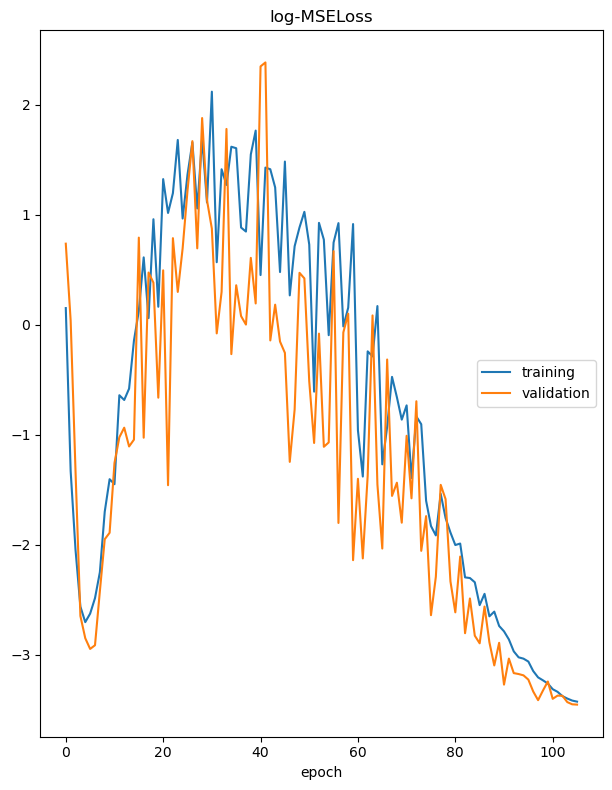

log-MSELoss
	training         	 (min:   -3.428, max:    2.120, cur:   -3.428)
	validation       	 (min:   -3.455, max:    2.386, cur:   -3.455)


In [23]:
output_small = output[0:10000]
#output_small = output_small.rename(columns = {"ids":"ID"})

output_small['ID'] = output_small['ID'].astype('string').astype('category')


columnsToKeep = ['ds','y', 'ID']
regressorsList = ['hour', 'day', 'day_of_week', 'month']

# now the cool one liner..
# this removes all columns not 'ds','y' or any regressors
df_regressors_only = output_small[output_small.columns.intersection(np.concatenate((columnsToKeep, regressorsList)))]

m = m.add_lagged_regressor(names=regressorsList)

df_train, df_test = m.split_df(df_regressors_only, freq='auto', valid_p=0.10, local_split=False)

metrics = m.fit(df_train, freq='auto', validation_df=df_test, progress="plot")

In [8]:
m.predict_trend(df_test)

,ds,trend,ID
0,2014-01-19 03:00:00,5.837621,MT_001
1,2014-01-19 04:00:00,5.837621,MT_001
2,2014-01-19 05:00:00,5.837621,MT_001
3,2014-01-19 06:00:00,5.837621,MT_001
4,2014-01-19 07:00:00,5.837621,MT_001
...,...,...,...
2016,2014-04-13 03:00:00,5.837621,MT_001
2017,2014-04-13 04:00:00,5.837621,MT_001
2018,2014-04-13 05:00:00,5.837621,MT_001
2019,2014-04-13 06:00:00,5.837621,MT_001


In [29]:
df_train

,ds,y,date,hour,day,day_of_week,month
0,2012-01-01 00:00:00,3.172589,2012-01-01 00:00:00,0,1,6,1
1,2012-01-01 01:00:00,4.124365,2012-01-01 01:00:00,1,1,6,1
2,2012-01-01 02:00:00,4.758883,2012-01-01 02:00:00,2,1,6,1
3,2012-01-01 03:00:00,4.441624,2012-01-01 03:00:00,3,1,6,1
4,2012-01-01 04:00:00,4.758883,2012-01-01 04:00:00,4,1,6,1
...,...,...,...,...,...,...,...
8998,2013-01-09 22:00:00,1.586294,2013-01-09 22:00:00,22,9,2,1
8999,2013-01-09 23:00:00,1.586294,2013-01-09 23:00:00,23,9,2,1
9000,2013-01-10 00:00:00,1.903553,2013-01-10 00:00:00,0,10,3,1
9001,2013-01-10 01:00:00,1.586294,2013-01-10 01:00:00,1,10,3,1


In [128]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast[forecast["ID"] == "MT_001"])

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972%

ValueError: Model has not been fitted. Predictions will be random.

# Transfer learning

In [12]:
stocks["val_dataloader"].dataset

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='High',
	group_ids=['group_id'],
	weight=None,
	max_encoder_length=168,
	min_encoder_length=84,
	min_prediction_idx=0,
	min_prediction_length=24,
	max_prediction_length=24,
	static_categoricals=[],
	static_reals=['High_center', 'High_scale'],
	time_varying_known_categoricals=['categorical_day_of_week', 'categorical_day', 'categorical_month'],
	time_varying_known_reals=['time_idx', 'day_of_week', 'day', 'month', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['Open', 'High', 'Low', 'Close', 'adj_close'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=False,
	target_normalizer=TorchNormalizer(method='identity', center=True, transformation=None, method_kwargs={}),
	categorical_encoders={'__group_id__group_id': NaNLabelEncoder(add_nan=False, warn=True), 'categorical_day_of_w

In [13]:
electricity["train_dataloader"].dataset

TimeSeriesDataSet[length=2197703](
	time_idx='time_idx',
	target='power_usage',
	group_ids=['categorical_id', 'id'],
	weight=None,
	max_encoder_length=168,
	min_encoder_length=84,
	min_prediction_idx=26304,
	min_prediction_length=1,
	max_prediction_length=24,
	static_categoricals=['categorical_id', 'id'],
	static_reals=['power_usage_center', 'power_usage_scale'],
	time_varying_known_categoricals=['categorical_day_of_week', 'categorical_hour', 'month'],
	time_varying_known_reals=['time_idx', 'hours_from_start', 'days_from_start', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['power_usage'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=False,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=['categorical_id', 'id'],
	center=True,
	scale_by_group=False,
	transformation='softplus',
	method_kwargs={}
),
	categorica

In [15]:
# load best pre trained model
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# load stocks timeseries
#stocks = dax_dataloader.create_stocks_timeseries()

timeseries_dict =  electricity
config_name_string = "electricity"
parameters = []


actuals = torch.cat([y[0] for x, y in iter(timeseries_dict["val_dataloader"])])
predictions = best_tft.predict(timeseries_dict["val_dataloader"])
print("Best model MAE: ",(actuals - predictions).abs().mean().item())


IndexError: index out of range in self

# Hyperparameters

In [ ]:
'''
still needs implementation, look here for error:
https://stackoverflow.com/questions/74157157/pytorch-lightning-got-an-unexpected-keyword-argument-weights-summary


needed to implement hyper optimization of QuantileLoss():
from torchmetrics.utilities import check_forward_full_state_property
check_forward_full_state_property


Parameter range used in Google paper:

state_size = [10, 20, 40, 80, 160, 240, 320]
dropout_rate =  [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
minibatch_size = [64, 128, 256]
learning_rate = [0.0001, 0.001, 0.01]
ma_gradient_norm = [0.01, 1.0, 100.0]
num_heads = [1, 2, 3, 4]

'''

# create study
study = optimize_hyperparameters(
    electricity_datasets['train_dataloader'],
    electricity_datasets["val_dataloader"],
    model_path="hyper_tuning",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(10, 320),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

KeyError: ignored

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x270 with 1 Axes>,
 'decoder_variables': <Figure size 504x270 with 1 Axes>}

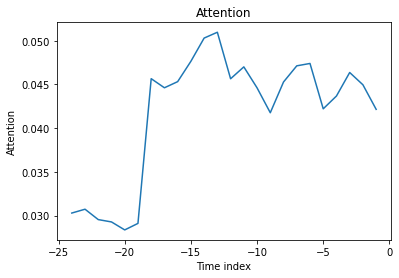

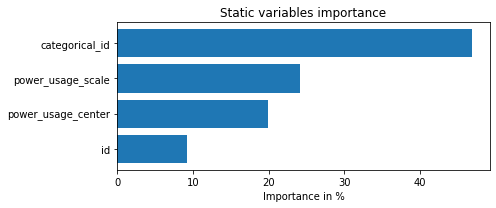

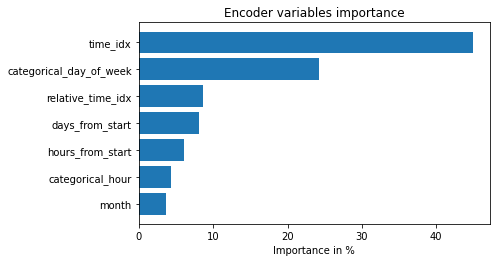

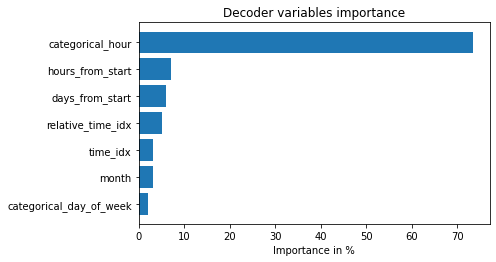

In [ ]:
#interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
#best_tft.plot_interpretation(interpretation)

In [ ]:
# predict on new data?!?!?!?! from documentation

# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
hi how are you?